#Import Required Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize images

In [ ]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Convert labels to one-hot encoding

In [ ]:

y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)

# Resize to DenseNet121 input size

In [ ]:
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label

# Batch size increased to 64


In [ ]:
batch_size = 64

# Create tf.data datasets (to avoid memory issues)

In [ ]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Load VGG16 as base model

In [ ]:
model2 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially

In [ ]:
model2.trainable = False

# Unfreeze last 50 layers for fine-tuning


In [ ]:
for layer in model2.layers[-50:]:
    layer.trainable = True

# Define the model

In [ ]:
model = models.Sequential([
    data_augmentation,
    model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")  # CIFAR-10 has 10 classes
])

# Compile the model


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Early stopping to prevent overfitting

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


#learning rate

In [ ]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train the model

In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=[early_stopping, lr_schedule])

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 411s 504ms/step - accuracy: 0.4767 - loss: 1.4358 - val_accuracy: 0.8319 - val_loss: 0.4940 - learning_rate: 1.0000e-04
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 403s 516ms/step - accuracy: 0.8011 - loss: 0.5878 - val_accuracy: 0.8523 - val_loss: 0.4265 - learning_rate: 1.0000e-04
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 389s 498ms/step - accuracy: 0.8507 - loss: 0.4362 - val_accuracy: 0.8784 - val_loss: 0.3589 - learning_rate: 1.0000e-04
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 388s 496ms/step - accuracy: 0.8730 - loss: 0.3746 - val_accuracy: 0.8980 - val_loss: 0.2906 - learning_rate: 1.0000e-04
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 388s 496ms/step - accuracy: 0.8907 - loss: 0.3188 - val_accuracy: 0.9031 - val_loss: 0.2807 - learning_rate: 1.0000e-04
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 387s 495ms/step - accuracy: 0.9036 - loss: 0.2836 - val_accuracy: 0.9003 - val_loss: 0.2971 - learning_rate: 1.0000e-04
Epoch 7/100
782/782 ━━━━━━━━━━━━━━

# Evaluate the model

In [ ]:
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 180ms/step


# Calculate and print evaluation metrics


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


# Confusion matrix visualization

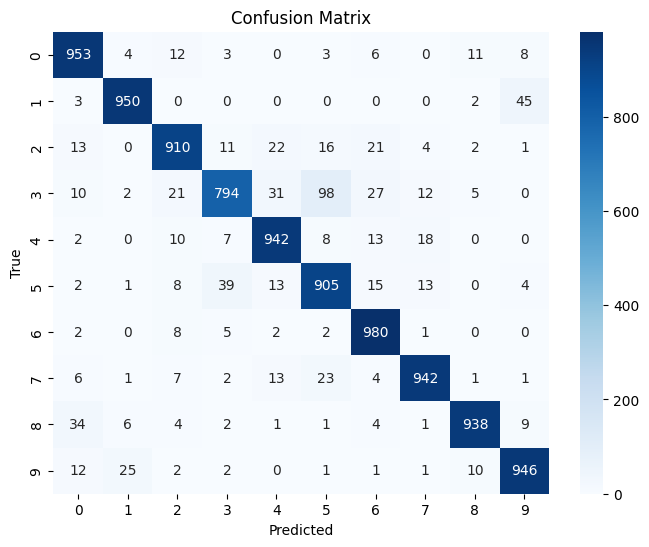

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Visualize some test images with predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


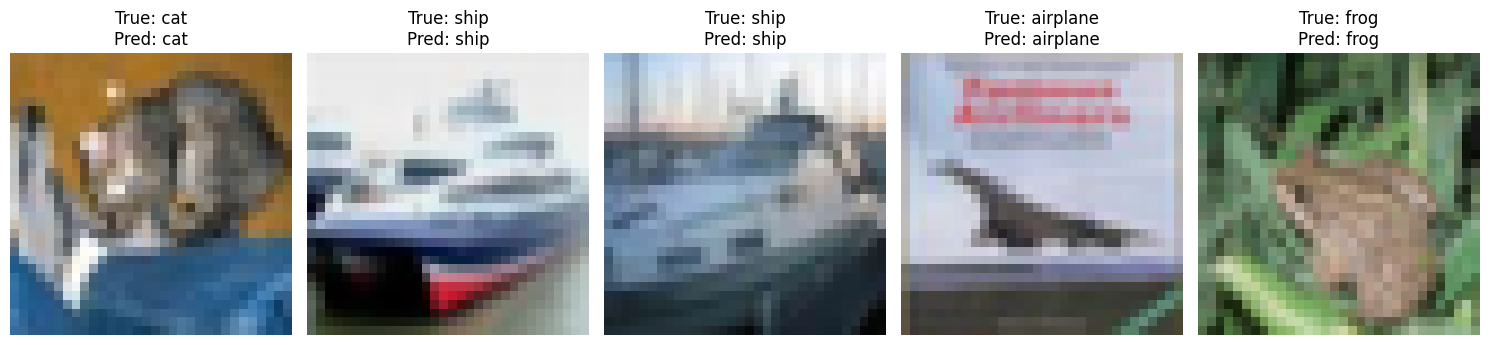

In [ ]:
def plot_images(images, true_labels, predicted_labels, class_names, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

test_images = X_test[:5]
test_images_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in test_images])
test_preds = model.predict(test_images_resized)
test_pred_classes = np.argmax(test_preds, axis=1)

plot_images(test_images, y_true[:5], test_pred_classes, class_names)

## Function to predict on custom images


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


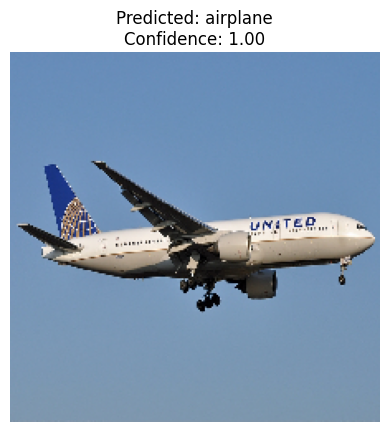

In [ ]:
def predict_custom_image(model, image_path, class_names):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)


    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)


    plt.imshow(image[0])
    plt.title(f"Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# (replace 'custom_image.jpg' with your image path)
predict_custom_image(model, '/content/United_Airlines_Boeing_777-200_Meulemans.jpg', class_names)